In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import numpy as np
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as K


2023-09-29 16:20:21.555483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:20:29.178054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2023-09-29 16:20:51.270572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-09-29 16:20:51.278024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
image_height = 192
image_width = 256
batch_size = 64
class_names = ['im_Dyskeratotic', 'im_Superficial-Intermediate', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal']

In [5]:
dataset_train_original, dataset_valid_original = image_dataset_from_directory('SipakMed_whole',
                                                            labels='inferred',
                                                            label_mode='int',
                                                            class_names=class_names,
                                                            image_size=(image_height,image_width),
                                                            batch_size=None,
                                                            shuffle=True,
                                                            seed=23,
                                                            validation_split=0.2,
                                                            subset='both',
                                                            crop_to_aspect_ratio=False)

Found 966 files belonging to 5 classes.
Using 773 files for training.
Using 193 files for validation.


2023-09-29 16:21:35.039300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


2023-09-28 21:32:48.902849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [773]
	 [[{{node Placeholder/_4}}]]
2023-09-28 21:32:48.903131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [773]
	 [[{{node Placeholder/_4}}]]


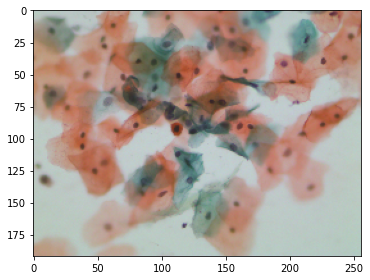

In [6]:
for i,l in dataset_train_original.take(1):
    # print(max(np.array(i).flatten()))
    j = np.array(i).astype(int)
    plt.imshow(j)
    plt.tight_layout()
    plt.show()


In [7]:
max(np.array(i).flatten())

216.75

In [6]:
tf.keras.backend.clear_session()

In [7]:
def preprocess(image, label):
    # image = image / 255.0
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # label = tf.cast(label, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label


In [8]:
# Functions to randomly augment the images

def augment_geometric(image, label, flip_left_right=True, flip_up_down=True):
    image_augmented = image
    if flip_left_right:
        image_augmented = tf.image.random_flip_left_right(image_augmented)
    if flip_up_down:
        image_augmented = tf.image.random_flip_up_down(image_augmented)
    return image_augmented, label

def augment_appearance(image, label, hue=0.25, brightness=0.25, contrast=0.5, saturation=0.5):
    image_augmented = image
    if hue > 0:
        image_augmented = tf.image.random_hue(image_augmented, hue)
    if brightness > 0:
        image_augmented = tf.image.random_brightness(image_augmented, brightness)
    if contrast > 0:
        image_augmented = tf.image.random_contrast(image_augmented, lower=max(0, 1.0-contrast), upper=1.0+contrast)
    if saturation > 0:
        image_saturation = tf.image.random_saturation(image_augmented, lower=max(0, 1.0-saturation), upper=1.0+saturation)
    image_augmented = tf.clip_by_value(image_augmented, 0.0, 1.0)
    return image_augmented, label


In [9]:
# Functions to systematically augment the images

def augment_all_geometric(image, label, flip_left_right=True, flip_up_down=True):
    image_augmented = image
    if flip_left_right:
        image_augmented = tf.image.flip_left_right(image_augmented)
    if flip_up_down:
        image_augmented = tf.image.flip_up_down(image_augmented)
    return image_augmented, label


In [10]:

def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

#    plt.plot(history["class2_recall"], label="class2_recall")
#    plt.plot(history["val_class2_recall"], label="val_class2_recall")
#    plt.legend()
#    plt.title("Our class2_recall")
#    plt.show()
#    plt.close()

    

In [ ]:
history_list = {}

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()
#     for training_name, history in history_list.items():
#         plt.plot(history["val_class2_recall"], label=training_name)
#     plt.legend()
#     plt.title("Comparison of val_class2_recall")
#     plt.show()
#     plt.close()
   

In [11]:
def class_recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())

def class_precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())
    
def class2_recall(y_true, y_pred):
    return class_recall(y_true, y_pred, 2)

def class2_precision(y_true, y_pred):
    return class_precision(y_true, y_pred, 2)


In [12]:
# Preprocess the datasets

dataset_train = dataset_train_original.map(lambda x, y: preprocess(x,y))
dataset_valid = dataset_valid_original.map(lambda x, y: preprocess(x,y))


In [13]:
# Augment the train dataset

dataset_augmented_geom_1 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=True,flip_up_down=False))
dataset_augmented_geom_2 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=False,flip_up_down=True))
dataset_augmented_geom_3 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=True,flip_up_down=True))

dataset_train = dataset_train.concatenate(dataset_augmented_geom_1)
dataset_train = dataset_train.concatenate(dataset_augmented_geom_2)
dataset_train = dataset_train.concatenate(dataset_augmented_geom_3)


In [13]:
images, labels = zip(*dataset_train)
print(len(images))
del images, labels

2023-09-28 21:37:45.256047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype int32 and shape [773]
	 [[{{node Placeholder/_36}}]]
2023-09-28 21:37:45.256479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_53' with dtype int32 and shape [773]
	 [[{{node Placeholder/_53}}]]


3092


In [14]:
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(3092)
dataset_train = dataset_train.batch(batch_size)

dataset_valid = dataset_valid.cache()
dataset_valid = dataset_valid.batch(batch_size)

In [15]:
model_name = "vgg19_whole_slide"
epochs = 10
lr = 0.0001


In [16]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG19(
    include_top=False,
    # pooling='max',
    weights='imagenet',
    # classes=5,
    # classifier_activation='softmax',
    input_shape=(image_height,image_width,3)
)
base_net.trainable = False
x = base_net.output
# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
x = layers.Dense(256, activation='relu')(x)
# x = layers.Dense(4096, activation='relu')(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=base_net.input, outputs=predictions)

# for layer in base_model.layers:
#    layer.trainable = False
    
# model = models.Sequential()
# model.add(base_net)

# model.add(layers.Flatten())
# model.add(layers.Dense(4096, activation="relu"))
# model.add(layers.Dense(4096, activation="relu"))
# model.add(layers.Dense(5, activation="softmax"))

model.summary(show_trainable=True)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 192, 256, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 192, 256, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 96, 128, 64)       0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 96, 128, 128)      73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 96, 128, 128)      147584

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
)


Epoch 1/10


2023-09-29 16:22:13.819590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype string and shape [773]
	 [[{{node Placeholder/_32}}]]
2023-09-29 16:22:13.820150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype string and shape [773]
	 [[{{node Placeholder/_32}}]]
2023-09-29 16:22:29.319955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-29 16:22:38.765105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-2

49/49 [==============================] - ETA: 0s - loss: 2.1156 - accuracy: 0.3296

2023-09-29 16:22:44.135742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [193]
	 [[{{node Placeholder/_0}}]]
2023-09-29 16:22:44.135988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [193]
	 [[{{node Placeholder/_4}}]]


49/49 [==============================] - 31s 83ms/step - loss: 2.1156 - accuracy: 0.3296 - val_loss: 1.3470 - val_accuracy: 0.5233
Epoch 2/10
49/49 [==============================] - 3s 51ms/step - loss: 1.1287 - accuracy: 0.5844 - val_loss: 0.9705 - val_accuracy: 0.6684
Epoch 3/10
49/49 [==============================] - 3s 52ms/step - loss: 0.8513 - accuracy: 0.7089 - val_loss: 0.8041 - val_accuracy: 0.7409
Epoch 4/10
49/49 [==============================] - 3s 52ms/step - loss: 0.7278 - accuracy: 0.7477 - val_loss: 0.7140 - val_accuracy: 0.7772
Epoch 5/10
49/49 [==============================] - 3s 52ms/step - loss: 0.6243 - accuracy: 0.7775 - val_loss: 0.6906 - val_accuracy: 0.7513
Epoch 6/10
49/49 [==============================] - 3s 52ms/step - loss: 0.5570 - accuracy: 0.8017 - val_loss: 0.6425 - val_accuracy: 0.7824
Epoch 7/10
49/49 [==============================] - 3s 52ms/step - loss: 0.5157 - accuracy: 0.8218 - val_loss: 0.5344 - val_accuracy: 0.8135
Epoch 8/10
49/49 [=====

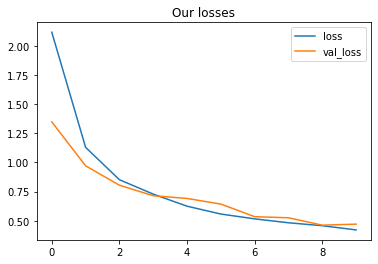

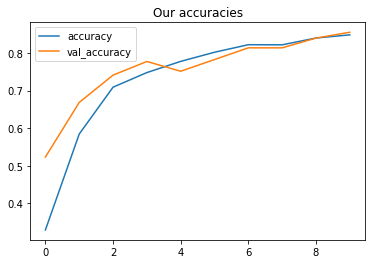

In [19]:
# history_list[model_name] = history.history
render_history(history.history)
# compare_histories()

In [20]:
# model_name = model_name + "_2"
epochs = 10
lr = 0.00005


In [21]:
# for layer in model.layers:
#    layer.trainable = True
base_net.trainable = True

In [22]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True
23 dropout True
24 dense True
25 dense_1 True


In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    # callbacks=[WandbMetricsLogger()],
)


Epoch 1/10
49/49 [==============================] - 21s 170ms/step - loss: 1.1339 - accuracy: 0.5828 - val_loss: 0.6004 - val_accuracy: 0.7979
Epoch 2/10
49/49 [==============================] - 6s 130ms/step - loss: 0.4917 - accuracy: 0.8231 - val_loss: 0.4667 - val_accuracy: 0.8497
Epoch 3/10
49/49 [==============================] - 6s 131ms/step - loss: 0.2855 - accuracy: 0.8952 - val_loss: 0.3357 - val_accuracy: 0.8912
Epoch 4/10
49/49 [==============================] - 6s 131ms/step - loss: 0.2176 - accuracy: 0.9140 - val_loss: 0.2709 - val_accuracy: 0.8912
Epoch 5/10
49/49 [==============================] - 6s 131ms/step - loss: 0.1593 - accuracy: 0.9395 - val_loss: 0.3467 - val_accuracy: 0.9067
Epoch 6/10
49/49 [==============================] - 7s 133ms/step - loss: 0.1410 - accuracy: 0.9544 - val_loss: 0.3890 - val_accuracy: 0.8446
Epoch 7/10
49/49 [==============================] - 6s 132ms/step - loss: 0.0877 - accuracy: 0.9702 - val_loss: 0.2492 - val_accuracy: 0.9171
Epoch

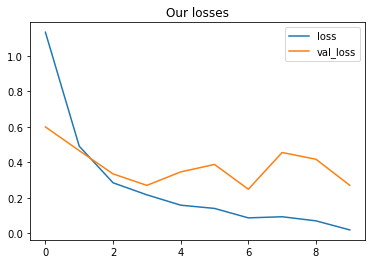

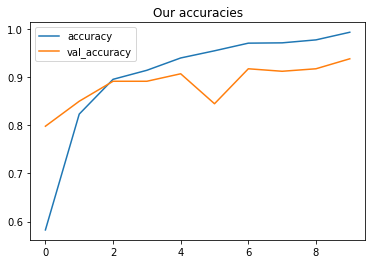

In [25]:
# history_list[model_name] = history.history
render_history(history.history)
# compare_histories()

In [26]:
# model_name = model_name.replace("_2","_3")
epochs = 5
lr = 0.00001


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [28]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
)


Epoch 1/5
49/49 [==============================] - 10s 135ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.2874 - val_accuracy: 0.9430
Epoch 2/5
49/49 [==============================] - 6s 131ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.2629 - val_accuracy: 0.9430
Epoch 3/5
49/49 [==============================] - 6s 130ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.3745 - val_accuracy: 0.9326
Epoch 4/5
49/49 [==============================] - 6s 131ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.3651 - val_accuracy: 0.9223
Epoch 5/5
49/49 [==============================] - 6s 131ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.3013 - val_accuracy: 0.9482


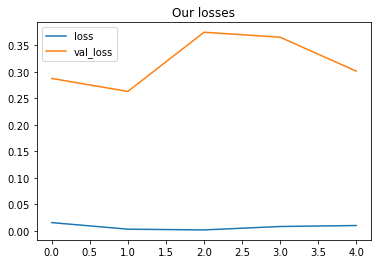

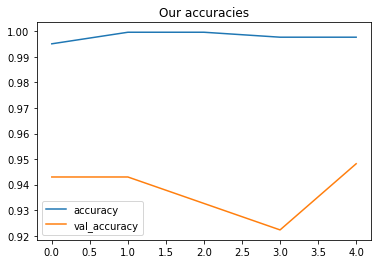

In [29]:
# history_list[model_name] = history.history
render_history(history.history)
# compare_histories()

In [30]:
model.save(model_name+'.h5', save_format='h5')

In [31]:
pred = model.predict(dataset_valid)
predictions = []
for p in pred:
    predictions.append(p.argmax())


4/4 [==============================] - 0s 60ms/step


In [32]:
images, labels = zip(*dataset_valid.unbatch())
conf_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions, dtype=float).numpy()
print(conf_matrix)

[[42.  0.  0.  0.  0.]
 [ 0. 29.  0.  0.  0.]
 [ 1.  0. 48.  1.  0.]
 [ 2.  1.  4. 47.  0.]
 [ 1.  0.  0.  0. 17.]]


2023-09-29 16:26:15.393248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [193]
	 [[{{node Placeholder/_0}}]]
2023-09-29 16:26:15.393501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [193]
	 [[{{node Placeholder/_4}}]]


In [33]:
conf_matrix_percentual = np.array(conf_matrix)
for row in range(5):
    conf_matrix_percentual[row, :] /= labels.count(row)
    conf_matrix_percentual[row, :] *= 100
print(conf_matrix_percentual.round(1))

[[100.    0.    0.    0.    0. ]
 [  0.  100.    0.    0.    0. ]
 [  2.    0.   96.    2.    0. ]
 [  3.7   1.9   7.4  87.    0. ]
 [  5.6   0.    0.    0.   94.4]]


In [34]:
c2_recall = (np.array(class2_recall(labels,pred))* 100).round(2)
print('Class 2 recall:', c2_recall)

Class 2 recall: 96.0


In [35]:
# labels=list(labels)
# labels_numpy = [l.numpy() for l in labels]

In [35]:
print('Class 4 recall:', (np.array(class_recall(labels,pred,4)*100).round(2)))

Class 4 recall: 94.44


In [36]:
c = 4
print(f'Class {c} precision:', (np.array(class_precision(labels,pred,c)*100).round(2)))


Class 4 precision: 100.0


In [37]:
def micro_precision(conf_matrix):
    tp = sum(np.diag(conf_matrix))
    fp = 0
    for i in range(5):
        for j in range(5):
            if i != j:
                fp += conf_matrix[i,j]
    return (tp / (tp + fp))

In [38]:
micro_precision(conf_matrix)

0.9481865284974094

In [39]:
def macro_precision(conf_matrix):
    precisions = []
    for i in range(5):
        den = 0
        for j in range(5):
            den += conf_matrix[j,i]
        precisions.append(conf_matrix[i,i]/den)
    return sum(precisions)/len(precisions)


In [40]:
print(macro_precision(conf_matrix))

0.9563907469342251


In [41]:
p = []
for c in range(5):
    p.append(class_precision(labels, pred, c))
print(sum(p)/len(p))
    

tf.Tensor(0.95639074, shape=(), dtype=float32)


In [42]:
macro_recall = sum(np.diag(conf_matrix_percentual)) / len(np.diag(conf_matrix_percentual))

In [43]:
print(macro_recall)

95.49629669189453


In [44]:
def micro_recall(conf_matrix):
    tp = sum(np.diag(conf_matrix))
    fn = 0
    for i in range(5):
        for j in range(5):
            if i != j:
                fn += conf_matrix[j,i]
    return (tp / (tp + fn))

In [45]:
print(micro_recall(conf_matrix))

0.9481865284974094


In [46]:
f1_tot = 0
for c in range(5):
    f1_score = 2 * class_precision(labels,pred,c) * class_recall(labels,pred,c) / (class_precision(labels,pred,c) + class_recall(labels,pred,c))
    print(f'F1-score class {c}: {f1_score}')
    f1_tot += f1_score
print(f'Macro-averages F1-score: {f1_tot/5}')

F1-score class 0: 0.9545454382896423
F1-score class 1: 0.9830508232116699
F1-score class 2: 0.9411764740943909
F1-score class 3: 0.9215686321258545
F1-score class 4: 0.9714285731315613
Macro-averages F1-score: 0.9543539881706238
